In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
filepath = 'dichalcogenides_public/'
targets = pd.read_csv(filepath + 'targets.csv', index_col=0)

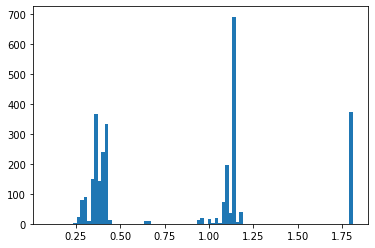

In [32]:
out = plt.hist(targets, bins=86)
plt.show()

In [43]:
(out[1][np.where(out[0]==692)[0][0]], out[1][np.where(out[0]==692)[0][0]+1])

(1.1319046511627906, 1.1518662790697674)

In [51]:
out[0]

array([  1.,   1.,   0.,   1.,   0.,   1.,   0.,   2.,  24.,  81.,  90.,
         9., 151., 366., 144., 239., 332.,  14.,   0.,   0.,   1.,   0.,
         1.,   0.,   0.,   0.,   0.,   8.,  11.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,  20.,
         0.,  17.,   2.,  19.,   2.,  74., 196.,  35., 692.,   5.,  39.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 374.])

In [50]:
(692+374+366+332) / out[0].sum()

0.5947403910991234

In [126]:
import os

filepath_train = '../Data/dichalcogenides_public/structures/'
train_files = os.listdir(filepath_train)

filepath_test = '../Data/dichalcogenides_private/structures/'
test_files = os.listdir(filepath_test)

targets = pd.read_csv('../Data/dichalcogenides_public/targets.csv', index_col=0)

In [118]:
# Returns euclidean norm of 2D vector
def norm(v):
    return np.sqrt(v[0] * v[0] + v[1] * v[1])

# Returns the vector joining l1[i,j] with the pixel in l2
# that is closer and has the same value
def movement_vector(l1, l2, i, j):
    n, m = l2.shape
    min_dist = 100
    v = (-100,-100)
    for ii in range(n):
        for jj in range(m):
            if (l1[i,j] == l2[ii,jj]):
                n = norm((ii-i, jj-j))
                if n == 0:
                    return (ii-i, jj-j)
                if n < min_dist:
                    v = (ii-i, jj-j)
                    min_dist = n
    return v

# Computes the distance between two layers as the sum of
# the norm of the movement vectors of all pixels
def dist_layer(l1, l2):
    n, m = l1.shape
    d = 0
    for i in range(n):
        for j in range(m):
            v = movement_vector(l1, l2, i, j)
            if v[0] == -100:
                d += 15
            else:
                d += norm(v)
    return d

# Computes distance between l1 and l2 considering possible 
# transformation like rotations and symmetries
def dist_layer_sim(l1, l2):
    d = dist_layer(l1, l2)
    d_sim_h = dist_layer(l1, l2[:,::-1])
    d_sim_v = dist_layer(l1, l2[::-1,:])
    d_sim = dist_layer(l1, l2[::-1,::-1])
    d_rot_1 = dist_layer(l1, np.rot90(l2))
    d_rot_2 = dist_layer(l1, np.rot90(l2, k=2))
    d_rot_3 = dist_layer(l1, np.rot90(l2, k=3))
    return np.min([d, d_sim_v, d_sim_h, d_sim, d_rot_1, d_rot_2, d_rot_3])

# Computes distance between two crystals
def dist(im1, im2):
    d = dist_layer_sim(im1[:,:,1], im2[:,:,1])
    
    d00 = dist_layer_sim(im1[:,:,0], im2[:,:,0])
    d02 = dist_layer_sim(im1[:,:,0], im2[:,:,2])
    d20 = dist_layer_sim(im1[:,:,2], im2[:,:,0])
    d22 = dist_layer_sim(im1[:,:,2], im2[:,:,2])
    
    d += min(d00+d22, d02+d20)
    return d

In [139]:
%%time
k1, k2 = 0, 11

im1 = np.load(filepath + 'images/' + train_files[k1][:-5] + '.npy')
im2 = np.load(filepath + 'images/' + train_files[k2][:-5] + '.npy')

print('Crystal distance:', dist(im1, im2))
print('Band gap distance:', np.abs(targets.loc[train_files[k1][:-5]] - targets.loc[train_files[k2][:-5]])[0])

Crystal distance: 34.0
Band gap distance: 0.8537
CPU times: user 168 ms, sys: 4.16 ms, total: 173 ms
Wall time: 185 ms


In [147]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [168]:
k1 = 500
im1 = np.load(filepath + 'images/' + train_files[k1][:-5] + '.npy')
crystal_dist = []
band_gap_dist = []
for k2 in range(100):
    if k2 != k1: 
        im2 = np.load(filepath + 'images/' + train_files[k2][:-5] + '.npy')
        crystal_dist.append(dist(im1, im2))
        band_gap_dist.append(np.abs(targets.loc[train_files[k1][:-5]] - targets.loc[train_files[k2][:-5]])[0])

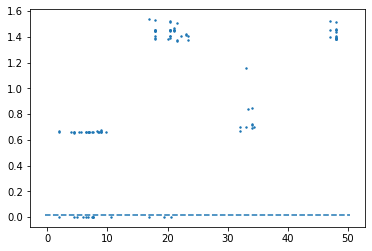

In [169]:
plt.scatter(crystal_dist, band_gap_dist, s=2)
abline(0,0.02)
plt.show()

In [170]:
targets.loc[train_files[k1][:-5]]

band_gap    1.8057
Name: 6141cfb49cbada84a867684b, dtype: float64